In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np
from nff.io.ase_calcs import NeuralFF

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

/home/dux/NeuralForceField/models


Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3_001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)
logging.getLogger(
    "matplotlib.font_manager"
).disabled = True  # disable matplotlib font manager logging

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/SrTiO3_001/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/SrTiO3_001/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

10:07:00 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
10:07:00 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

10:07:00 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3_001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
10:07:00 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
10:07:00 - mcmc.system | INFO: Initializing 64 virtual atoms
10:07:00 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10:07:00 - mcmc.system | INFO: Number of pristine atoms is 60
10:07:00 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
10:07:00 - mcmc.

      Step     Time          Energy          fmax
BFGS:    0 10:07:02     -467.521881        0.204407
BFGS:    1 10:07:02     -467.525757        0.180273
BFGS:    2 10:07:02     -467.540619        0.079328
BFGS:    3 10:07:02     -467.540924        0.059823
BFGS:    4 10:07:02     -467.541351        0.005870


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

10:07:03 - mcmc.mcmc | INFO: Using run folder SrTiO3_001
10:07:03 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
10:07:03 - mcmc.mcmc | INFO: Running with total_sweeps = 10, sweep_size = 5, start_temp = 1.000
10:07:03 - mcmc.mcmc | INFO: Starting with iteration 0
10:07:03 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
10:07:03 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:07:03     -468.047943       13.644413
BFGS:    1 10:07:03     -469.902222        4.257286
BFGS:    2 10:07:03     -470.302765        1.848279
BFGS:    3 10:07:03     -470.448517        0.937589
BFGS:    4 10:07:03     -470.502319        0.784208
BFGS:    5 10:07:04     -470.572266        0.435066
BFGS:    6 10:07:04     -470.611481        0.449032
BFGS:    7 10:07:04     -470.628204        0.671624
BFGS:    8 10:07:04     -470.381256        2.700147
BFGS:    9 10:07:04     -470.649261        0.671251
BFGS:   10 10:07:05     -470.659332        0.641276
BFGS:   11 10:07:05     -470.691010        0.529939
BFGS:   12 10:07:05     -470.701172        0.464180
BFGS:   13 10:07:05     -470.724457        0.270366
BFGS:   14 10:07:06     -470.727051        0.137828
BFGS:   15 10:07:06     -470.729492        0.117855
BFGS:   16 10:07:06     -470.730804        0.132777
BFGS:   17 10:07:06     -470.731598        0.110335
BFGS:   18 10:

10:07:25 - mcmc.system | INFO: Optimized structure has surface energy = 10.643
10:07:25 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:07:25     -446.097412       67.091261
BFGS:    1 10:07:26     -462.391632       26.886955
BFGS:    2 10:07:26     -468.394775       17.070749
BFGS:    3 10:07:26     -472.648407       10.057305
BFGS:    4 10:07:26     -475.249420        6.158516
BFGS:    5 10:07:27     -476.881927        4.294027
BFGS:    6 10:07:27     -477.939056        2.597173
BFGS:    7 10:07:27     -478.381348        3.006327
BFGS:    8 10:07:28     -478.828583        3.421656
BFGS:    9 10:07:28     -479.445038        3.712381
BFGS:   10 10:07:28     -480.029755        3.014633
BFGS:   11 10:07:28     -480.507202        2.394754
BFGS:   12 10:07:28     -480.953735        2.596301
BFGS:   13 10:07:29     -481.332550        2.741582
BFGS:   14 10:07:29     -481.862305        2.489037
BFGS:   15 10:07:29     -482.250854        2.113957
BFGS:   16 10:07:29     -482.503998        1.974578
BFGS:   17 10:07:29     -482.780426        1.681017
BFGS:   18 10:

10:07:46 - mcmc.system | INFO: Optimized structure has surface energy = 9.490
10:07:46 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:07:46     -446.857819       64.835711
BFGS:    1 10:07:46     -463.641235       24.956379
BFGS:    2 10:07:46     -470.958221       14.532101
BFGS:    3 10:07:46     -476.034027        8.156289
BFGS:    4 10:07:47     -479.151764        4.207033
BFGS:    5 10:07:47     -480.936859        2.236077
BFGS:    6 10:07:47     -481.841187        1.928059
BFGS:    7 10:07:47     -482.182495        1.797030
BFGS:    8 10:07:47     -482.806488        3.536799
BFGS:    9 10:07:47     -483.248260        2.413343
BFGS:   10 10:07:47     -483.733734        1.261910
BFGS:   11 10:07:48     -483.854584        1.302530
BFGS:   12 10:07:48     -484.093658        1.526466
BFGS:   13 10:07:48     -484.372955        1.803537
BFGS:   14 10:07:48     -484.679901        1.807443
BFGS:   15 10:07:48     -485.072998        2.149097
BFGS:   16 10:07:48     -485.426361        2.478797
BFGS:   17 10:07:49     -485.721588        2.372428
BFGS:   18 10:

10:08:04 - mcmc.system | INFO: Optimized structure has surface energy = 7.244
10:08:04 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:08:04     -453.464996       67.578112
BFGS:    1 10:08:04     -472.656342       28.319092
BFGS:    2 10:08:04     -481.944702       18.110983
BFGS:    3 10:08:05     -488.852539       11.921911
BFGS:    4 10:08:05     -493.212799        7.059559
BFGS:    5 10:08:05     -495.572174        4.794649
BFGS:    6 10:08:05     -497.145721        3.146207
BFGS:    7 10:08:05     -498.102936        2.423294
BFGS:    8 10:08:06     -498.815826        2.518794
BFGS:    9 10:08:06     -499.384033        3.070525
BFGS:   10 10:08:06     -500.299530        2.895494
BFGS:   11 10:08:06     -500.645294        1.766248
BFGS:   12 10:08:06     -501.152191        1.690305
BFGS:   13 10:08:06     -501.560669        2.219827
BFGS:   14 10:08:06     -501.896149        2.392355
BFGS:   15 10:08:06     -502.410065        2.136756
BFGS:   16 10:08:06     -502.796539        2.042862
BFGS:   17 10:08:06     -503.223175        1.515847
BFGS:   18 10:

10:08:21 - mcmc.system | INFO: Optimized structure has surface energy = 8.257
10:08:21 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:08:21     -357.041412      165.907595
BFGS:    1 10:08:21     -420.410370      107.306416
BFGS:    2 10:08:21     -449.186371       64.300176
BFGS:    3 10:08:21     -465.727631       42.305498
BFGS:    4 10:08:22     -481.913849       26.419327
BFGS:    5 10:08:22     -492.524139       15.894928
BFGS:    6 10:08:22     -498.516510        8.501376
BFGS:    7 10:08:22     -502.083038        4.308381
BFGS:    8 10:08:22     -503.256439        8.504122
BFGS:    9 10:08:22     -504.460602        2.363761
BFGS:   10 10:08:22     -505.564941        2.494769
BFGS:   11 10:08:23     -506.279022        3.139295
BFGS:   12 10:08:23     -507.024658        3.308939
BFGS:   13 10:08:23     -507.998627        2.944256
BFGS:   14 10:08:23     -508.727448        2.987732
BFGS:   15 10:08:23     -509.188477        2.472855
BFGS:   16 10:08:23     -509.968750        3.343061
BFGS:   17 10:08:23     -510.271393        2.202648
BFGS:   18 10:

10:08:34 - mcmc.system | INFO: Optimized structure has surface energy = 8.257
10:08:34 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:08:34     -393.107635      171.584641
BFGS:    1 10:08:34     -447.747559       75.918214
BFGS:    2 10:08:34     -469.214935       53.394166
BFGS:    3 10:08:34     -484.437042       29.576447
BFGS:    4 10:08:34     -494.505524       18.957975
BFGS:    5 10:08:34     -499.981964       12.093645
BFGS:    6 10:08:34     -503.604248        7.585843
BFGS:    7 10:08:35     -505.831573        5.441567
BFGS:    8 10:08:35     -507.090912        4.087731
BFGS:    9 10:08:35     -508.059052        2.871097
BFGS:   10 10:08:35     -508.911377        2.679605
BFGS:   11 10:08:35     -510.339691        2.458251
BFGS:   12 10:08:35     -511.354950        2.290993
BFGS:   13 10:08:35     -511.984650        2.689228
BFGS:   14 10:08:36     -512.619080        2.369054
BFGS:   15 10:08:36     -513.529785        2.684913
BFGS:   16 10:08:36     -513.915710        2.541573
BFGS:   17 10:08:36     -514.531311        1.951378
BFGS:   18 10:

10:08:48 - mcmc.system | INFO: Optimized structure has surface energy = 4.589
10:08:48 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:08:48     -359.039398      189.135833
BFGS:    1 10:08:48     -430.957245       79.034549
BFGS:    2 10:08:48     -453.538239       76.672147
BFGS:    3 10:08:48     -472.873932       51.424603
BFGS:    4 10:08:49     -486.079132       33.698927
BFGS:    5 10:08:49     -495.464600       22.785327
BFGS:    6 10:08:49     -502.118011       15.139800
BFGS:    7 10:08:49     -506.861237       10.489931
BFGS:    8 10:08:49     -510.198608        7.315132
BFGS:    9 10:08:49     -512.744507        6.241527
BFGS:   10 10:08:49     -514.357361        5.400005
BFGS:   11 10:08:49     -515.343811        5.076230
BFGS:   12 10:08:49     -516.467102        4.064600
BFGS:   13 10:08:49     -517.715759        3.437828
BFGS:   14 10:08:50     -518.542480        3.397683
BFGS:   15 10:08:50     -519.416077        3.352732
BFGS:   16 10:08:50     -520.279358        2.741654
BFGS:   17 10:08:50     -521.192566        2.967243
BFGS:   18 10:

10:09:00 - mcmc.system | INFO: Optimized structure has surface energy = 5.464
10:09:00 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:09:00     -364.655273      452.207986
BFGS:    1 10:09:01     -263.977264     1740.661297
BFGS:    2 10:09:01     -382.196075      452.183038
BFGS:    3 10:09:01     -417.586517      279.703666
BFGS:    4 10:09:01     -424.826019      110.275503
BFGS:    5 10:09:01     -441.257080      126.330045
BFGS:    6 10:09:01     -457.463593      109.658521
BFGS:    7 10:09:01     -463.516998       50.693660
BFGS:    8 10:09:01     -467.305023       37.758848
BFGS:    9 10:09:02     -469.223267       19.595089
BFGS:   10 10:09:02     -472.218353       11.442482
BFGS:   11 10:09:02     -473.447540       59.812696
BFGS:   12 10:09:02     -474.774078       24.503242
BFGS:   13 10:09:02     -474.125244      117.313649
BFGS:   14 10:09:02     -476.471313       57.818260
BFGS:   15 10:09:02     -476.371979       86.636267
BFGS:   16 10:09:02     -477.179718       19.849765
BFGS:   17 10:09:03     -477.516235       13.549435
BFGS:   18 10:

10:09:13 - mcmc.system | INFO: Optimized structure has surface energy = 4.848
10:09:13 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:09:13     -384.806549      172.550168
BFGS:    1 10:09:13     -441.632294       71.639465
BFGS:    2 10:09:13     -466.560455       54.850167
BFGS:    3 10:09:13     -481.427368       37.542756
BFGS:    4 10:09:14     -491.887177       26.456288
BFGS:    5 10:09:14     -499.611053       18.383058
BFGS:    6 10:09:14     -505.359467       14.300229
BFGS:    7 10:09:14     -509.422760       10.495450
BFGS:    8 10:09:14     -511.900299        8.076932
BFGS:    9 10:09:14     -513.593689        6.202960
BFGS:   10 10:09:14     -514.872986        5.347211
BFGS:   11 10:09:14     -516.667419        4.345098
BFGS:   12 10:09:15     -518.156555        3.091788
BFGS:   13 10:09:15     -519.231995        3.218463
BFGS:   14 10:09:15     -519.871094        3.051903
BFGS:   15 10:09:15     -520.502136        2.352428
BFGS:   16 10:09:15     -521.037415        2.418547
BFGS:   17 10:09:15     -521.667786        2.723678
BFGS:   18 10:

10:09:27 - mcmc.system | INFO: Optimized structure has surface energy = 2.008
10:09:27 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy          fmax
BFGS:    0 10:09:28     -379.142426      169.462310
BFGS:    1 10:09:28     -441.629059       71.720507
BFGS:    2 10:09:28     -466.319427       62.713868
BFGS:    3 10:09:28     -483.670807       42.173800
BFGS:    4 10:09:28     -494.683716       29.697294
BFGS:    5 10:09:28     -503.180023       20.382905
BFGS:    6 10:09:28     -509.180389       14.123597
BFGS:    7 10:09:28     -513.549744       10.344283
BFGS:    8 10:09:28     -516.434021        6.816918
BFGS:    9 10:09:29     -518.114563        4.445232
BFGS:   10 10:09:29     -519.261047        3.833210
BFGS:   11 10:09:29     -520.438660        3.279362
BFGS:   12 10:09:29     -521.948547        2.695413
BFGS:   13 10:09:29     -523.234070        2.407184
BFGS:   14 10:09:29     -524.084534        1.744955
BFGS:   15 10:09:29     -524.605225        1.657558
BFGS:   16 10:09:29     -525.069641        1.912309
BFGS:   17 10:09:29     -525.410706        2.212478
BFGS:   18 10:

10:09:41 - mcmc.system | INFO: Optimized structure has surface energy = 2.443


Time taken = 158.301 seconds


Plot results

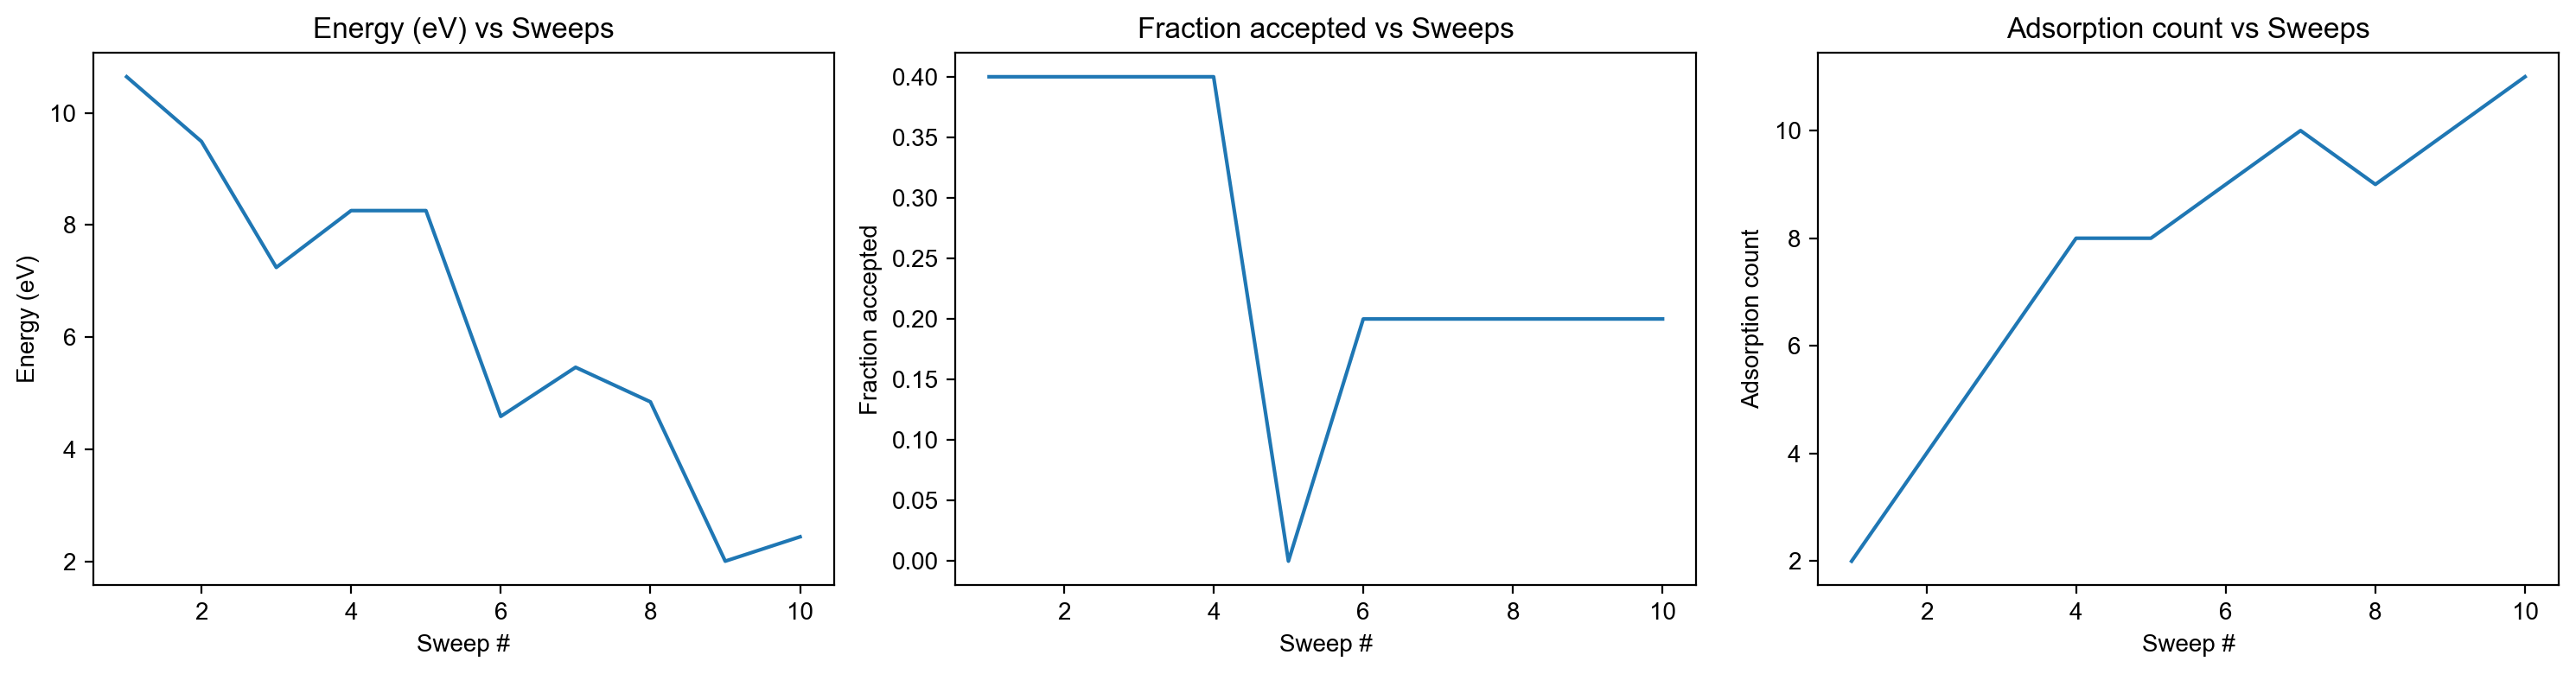

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)